In [74]:
# Cell 1: Initial Setup & Imports
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# For Decision Tree:
from sklearn.tree import DecisionTreeClassifier, plot_tree # plot_tree added here
# For Custom KNN:
from collections import Counter
import time
import zipfile
import shutil
import tkinter as tk
from tkinter import filedialog
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tkinter import ttk 
# Import ttk for themed widgets
# Set random seed for reproducibility
np.random.seed(42)
plt.style.use('ggplot')

# Create data directory if it does not exist
if not os.path.exists('data'):
    os.makedirs('data')

print("Initial setup and imports complete.")

Initial setup and imports complete.


In [75]:
# Cell 2: Custom KNN Classifier

class SimpleKNNClassifier:
    """
    A basic K-Nearest Neighbors (KNN) classifier implemented from scratch.
    """
    def __init__(self, n_neighbors=5):
        """
        Initializes the KNN classifier.

        Args:
            n_neighbors (int): The number of neighbors to consider for classification.
        """
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def _euclidean_distance(self, x1, x2):
        """
        Calculates the Euclidean distance between two data points.
        """
        return np.sqrt(np.sum((x1 - x2)**2))

    def fit(self, X_train, y_train):
        """
        Stores the training data.

        Args:
            X_train (numpy.ndarray): Training feature data.
            y_train (numpy.ndarray): Training labels.
        """
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        """
        Predicts the labels for the test data.

        Args:
            X_test (numpy.ndarray): Test feature data.

        Returns:
            numpy.ndarray: Predicted labels for each test data point.
        """
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)

    def _predict(self, x):
        """
        Predicts the label for a single test data point.
        """
        # Compute distances from x to all training points
        distances = [self._euclidean_distance(x, x_train_point) for x_train_point in self.X_train]

        # Get the k-nearest neighbors (indices)
        k_indices = np.argsort(distances)[:self.n_neighbors]

        # Get the labels of the k-nearest neighbors
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # Return the most common class label among the k-nearest neighbors
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

print("Custom SimpleKNNClassifier class defined.")

Custom SimpleKNNClassifier class defined.


In [76]:
# Cell 3: Data Loading & Preprocessing Function

def load_images_from_folder(folder_path, target_size=(128, 128)):
    """
    Loads images from subfolders (each subfolder is a class/person), resizes them,
    and converts to RGB.

    Args:
        folder_path (str): Path to the root folder containing subfolders of images.
        target_size (tuple): Desired size (width, height) for resizing images.

    Returns:
        tuple: A tuple containing:
               - numpy.ndarray: Array of loaded and processed images.
               - numpy.ndarray: Array of corresponding labels.
               - list: List of class names (person identities).
    """
    images = []
    labels = []
    # Sort class names to ensure consistent label mapping across runs
    class_names = sorted([d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))])
    label_map = {name: i for i, name in enumerate(class_names)}

    print(f"Loading images from: {folder_path}")
    print(f"Detected classes: {class_names}")

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path):
            continue

        print(f"  Processing class: {class_name}")
        for filename in os.listdir(class_path):
            # Check for common image file extensions
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                img_path = os.path.join(class_path, filename)
                try:
                    # Read image using OpenCV
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"    Warning: Could not read image {img_path}. Skipping.")
                        continue

                    # Resizing images to target_size
                    img = cv2.resize(img, target_size)
                    # Convert BGR (OpenCV default) to RGB (for consistency with PIL/matplotlib)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    images.append(img)
                    labels.append(label_map[class_name])
                except Exception as e:
                    print(f"    Error processing {img_path}: {e}")

    return np.array(images), np.array(labels), class_names
    print("Data loading function defined.")

In [77]:
# Cell 4: Feature Extraction Function (HOG + HSV)

def extract_features(images):
   
    all_features = []
    print("Extracting features (HOG + HSV)...")
    for i, img in enumerate(images):
        if i % 100 == 0:
            print(f"  Processing image {i}/{len(images)}")
             # HOG features (on grayscale image) 
        # Convert to grayscale as HOG operates on intensity gradients
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        hog_features, hog_image = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                                      cells_per_block=(2, 2), block_norm='L2-Hys',
                                      visualize=True) # Set visualize=True for later EDA

        # HSV color histogram features 
        # Convert RGB image to HSV color space
        hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        # Calculate histograms for H, S, V channels
        # Hue (H) typically ranges from 0-179 
        # Saturation (S) and Value (V) range from 0-255
        hist_h = cv2.calcHist([hsv_img], [0], None, [32], [0, 180]) # 32 bins for Hue
        hist_s = cv2.calcHist([hsv_img], [1], None, [16], [0, 256]) # 16 bins for Saturation
        hist_v = cv2.calcHist([hsv_img], [2], None, [16], [0, 256]) # 16 bins for Value

        # Normalizing histograms to make them robust to image size variations
        hist_h = cv2.normalize(hist_h, hist_h).flatten()
        hist_s = cv2.normalize(hist_s, hist_s).flatten()
        hist_v = cv2.normalize(hist_v, hist_v).flatten()

        # Concatenate HOG and HSV features into a single feature vector for the image
        combined_features = np.concatenate((hog_features, hist_h, hist_s, hist_v))
        all_features.append(combined_features)
        print(f"Feature extraction complete. Total features extracted: {len(all_features)}")
    return np.array(all_features)

print("Feature extraction function defined.")

Feature extraction function defined.


In [78]:
# Cell 5: Data Loading and Feature Extraction Execution

data_folder = 'Dataset (1)/dataset'

# Print current working directory and target data path 
print(f"Current working directory: {os.getcwd()}")
print(f"Attempting to load images from: {os.path.join(os.getcwd(), data_folder)}")

images, labels, class_names = load_images_from_folder(data_folder)

if len(images) == 0:
    print("No images loaded. Please check your 'Dataset (1)/dataset' folder structure and paths.")
    print("Ensure 'Dataset (1)' folder is directly inside the current working directory (as printed above).")
    print("Also ensure 'dataset' subfolder is inside 'Dataset (1)', and 'dataset' contains subfolders for each person (e.g., 'Dataset (1)/dataset/person1').")
    print("And make sure those subfolders contain actual image files (e.g., .jpg, .png, .jpeg).")
else:
    print(f"Total images loaded: {len(images)}")
    print(f"Total unique individuals (classes): {len(class_names)}")
    print(f"Image shape example: {images[0].shape}")

    # Extract features
    X = extract_features(images)
    y = labels

    print(f"Shape of extracted features (X): {X.shape}")
    print(f"Shape of labels (y): {y.shape}")

    # Split data into training and testing sets
    # stratify=y ensures that the proportion of classes is the same in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"\nTraining data shape (X_train): {X_train.shape}")
    print(f"Testing data shape (X_test): {X_test.shape}")
    print(f"Training labels shape (y_train): {y_train.shape}")
    print(f"Testing labels shape (y_test): {y_test.shape}")

    # Store labels as list for GUI
    labels_list = list(y)

Current working directory: C:\Users\Admin\Downloads\PYTHONFACIALRECOGNITION
Attempting to load images from: C:\Users\Admin\Downloads\PYTHONFACIALRECOGNITION\Dataset (1)/dataset
Loading images from: Dataset (1)/dataset
Detected classes: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11']
  Processing class: 01
  Processing class: 02
  Processing class: 03
  Processing class: 04
  Processing class: 05
  Processing class: 06
  Processing class: 07
  Processing class: 08
  Processing class: 09
  Processing class: 10
  Processing class: 11
Total images loaded: 3836
Total unique individuals (classes): 11
Image shape example: (128, 128, 3)
Extracting features (HOG + HSV)...
  Processing image 0/3836
Feature extraction complete. Total features extracted: 1
Feature extraction complete. Total features extracted: 2
Feature extraction complete. Total features extracted: 3
Feature extraction complete. Total features extracted: 4
Feature extraction complete. Total features extracted: 


 Performing Exploratory Data Analysis and Feature Visualization 

6.1: Visualizing Sample Images from the Dataset


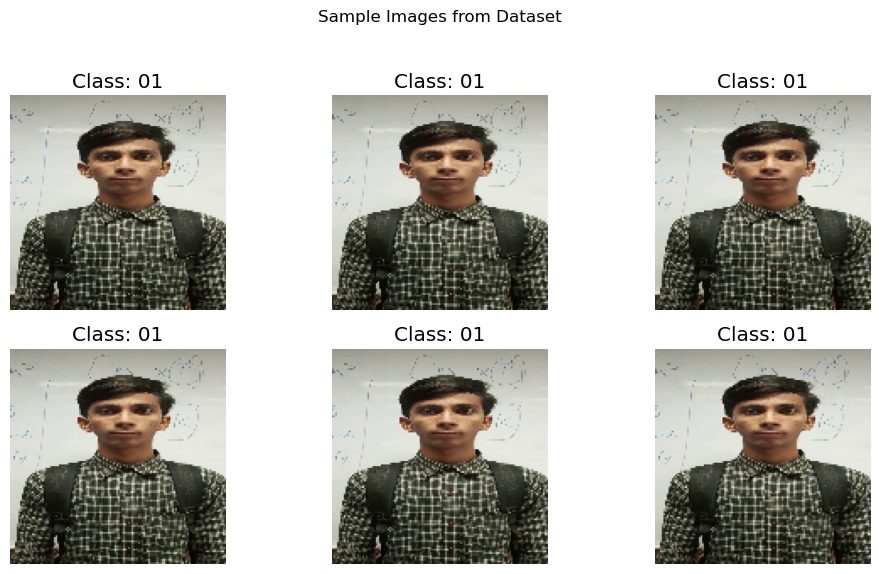

This visualization helps to see the diversity and quality of the raw input images.

6.2: Visualizing Image Preprocessing


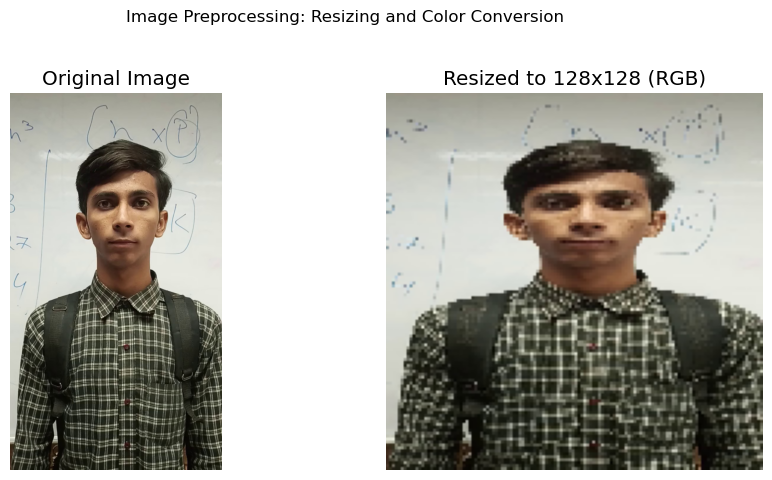

This shows how raw images are transformed into a consistent format for feature extraction.

6.3: Visualizing HOG Features


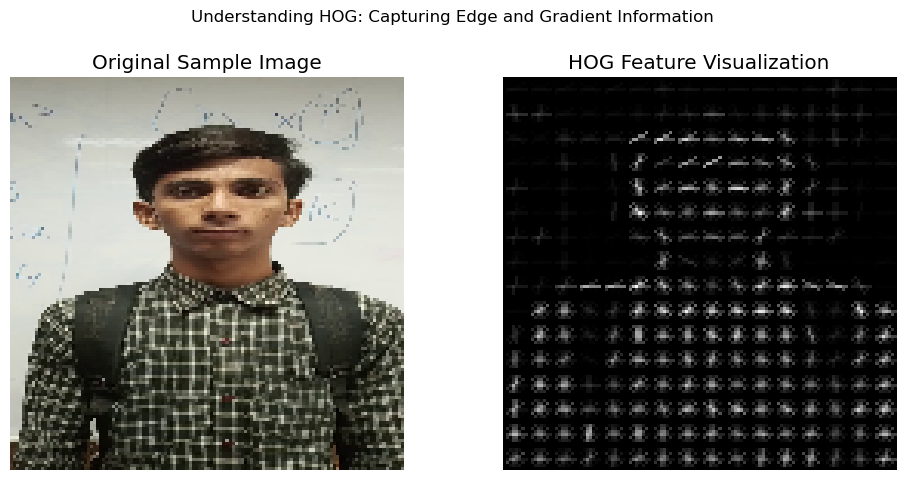

The HOG visualization highlights edges and gradients, which are key structural components of faces.
These patterns are highly discriminative for person identification.

6.4: Visualizing HSV Color Histograms


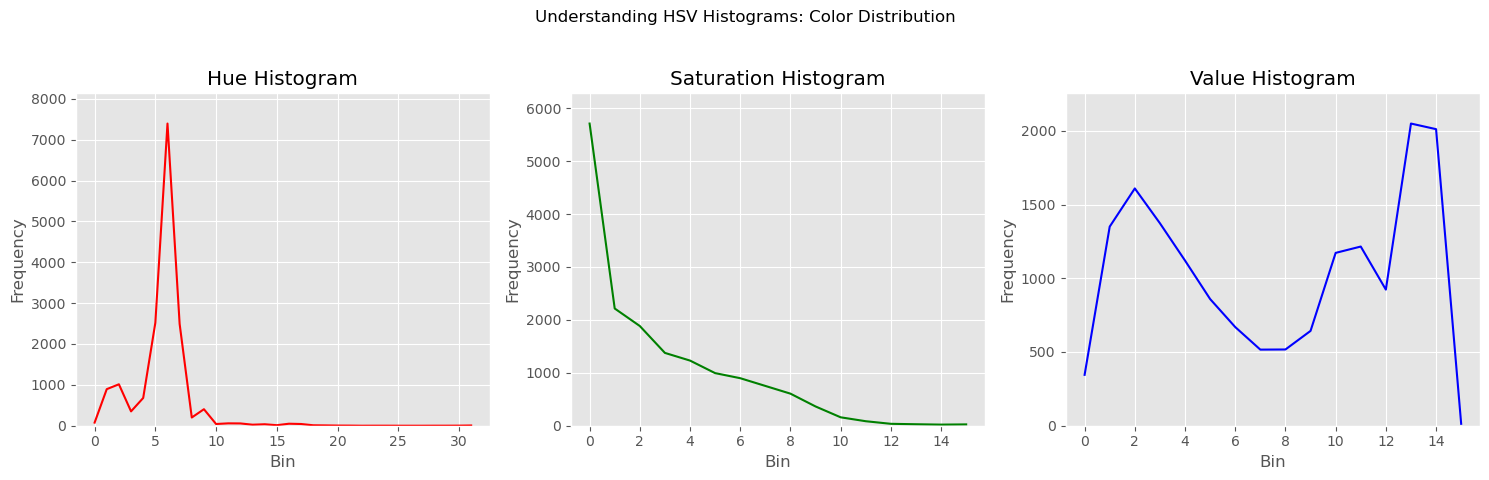

HSV histograms show the distribution of colors, saturation, and brightness.
These features are less sensitive to lighting changes and can capture skin tones and clothing colors.

EDA and Feature Visualization complete. These steps are crucial for understanding the data
and verifying that the feature extraction process is capturing relevant information.


In [79]:
# Cell 6: Exploratory Data Analysis & Feature Visualization 

print("\n Performing Exploratory Data Analysis and Feature Visualization ")

if len(images) > 0:
    # Visualize Sample Images from Dataset
    print("\n6.1: Visualizing Sample Images from the Dataset")
    plt.figure(figsize=(10, 6))
    for i in range(min(6, len(images))): # Display up to 6 images
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Class: {class_names[labels[i]]}")
        plt.axis('off')
    plt.suptitle("Sample Images from Dataset")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()
    print("This visualization helps to see the diversity and quality of the raw input images.")

    # Visualize Preprocessing (Original vs. Resized/RGB)
    print("\n6.2: Visualizing Image Preprocessing")
    sample_img_path = None
    # Try to find a sample image path for visualization
    if len(class_names) > 0:
        sample_class_path = os.path.join(data_folder, class_names[0])
        if os.path.isdir(sample_class_path):
            for fname in os.listdir(sample_class_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    sample_img_path = os.path.join(sample_class_path, fname)
                    break

    if sample_img_path:
        try:
            original_img = cv2.imread(sample_img_path)
            original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
            resized_img = cv2.resize(original_img, (128, 128))
            resized_img_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(original_img_rgb)
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(resized_img_rgb)
            plt.title(f"Resized to {resized_img_rgb.shape[0]}x{resized_img_rgb.shape[1]} (RGB)")
            plt.axis('off')
            plt.suptitle("Image Preprocessing: Resizing and Color Conversion")
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
            print("This shows how raw images are transformed into a consistent format for feature extraction.")
        except Exception as e:
            print(f"Could not visualize preprocessing for sample image: {e}")
    else:
        print("Could not find a sample image to visualize preprocessing.")


    # Visualize HOG Features for a Sample Image
    print("\n6.3: Visualizing HOG Features")
    sample_image_for_hog = images[0] # Take the first loaded image
    gray_sample_image = cv2.cvtColor(sample_image_for_hog, cv2.COLOR_RGB2GRAY)

    # Again extract HOG with visualization enabled for this specific sample
    _, hog_image_vis = hog(gray_sample_image, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image_for_hog)
    plt.title("Original Sample Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image_vis, cmap='gray') # HOG visualization is typically grayscale
    plt.title("HOG Feature Visualization")
    plt.axis('off')
    plt.suptitle("Understanding HOG: Capturing Edge and Gradient Information")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print("The HOG visualization highlights edges and gradients, which are key structural components of faces.")
    print("These patterns are highly discriminative for person identification.")


    # Visualize HSV Histograms for a Sample Image
    print("\n6.4: Visualizing HSV Color Histograms")
    hsv_sample_image = cv2.cvtColor(images[0], cv2.COLOR_RGB2HSV)

    # Calculate histograms (using the same bins as in extract features)
    hist_h = cv2.calcHist([hsv_sample_image], [0], None, [32], [0, 180])
    hist_s = cv2.calcHist([hsv_sample_image], [1], None, [16], [0, 256])
    hist_v = cv2.calcHist([hsv_sample_image], [2], None, [16], [0, 256])

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(hist_h, color='red')
    plt.title('Hue Histogram')
    plt.xlabel('Bin')
    plt.ylabel('Frequency')
    plt.ylim(0, max(hist_h)*1.1) # Adjust y-limit for better visualization

    plt.subplot(1, 3, 2)
    plt.plot(hist_s, color='green')
    plt.title('Saturation Histogram')
    plt.xlabel('Bin')
    plt.ylabel('Frequency')
    plt.ylim(0, max(hist_s)*1.1)

    plt.subplot(1, 3, 3)
    plt.plot(hist_v, color='blue')
    plt.title('Value Histogram')
    plt.xlabel('Bin')
    plt.ylabel('Frequency')
    plt.ylim(0, max(hist_v)*1.1)

    plt.suptitle("Understanding HSV Histograms: Color Distribution")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print("HSV histograms show the distribution of colors, saturation, and brightness.")
    print("These features are less sensitive to lighting changes and can capture skin tones and clothing colors.")

    print("\nEDA and Feature Visualization complete. These steps are crucial for understanding the data")
    print("and verifying that the feature extraction process is capturing relevant information.")
else:
    print("Skipping EDA and Feature Visualization: No images loaded. Please check Cell 5.")

In [80]:
# Cell 7: Feature Scaling

if 'X_train' in locals() and 'X_test' in locals():
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("Features scaled using StandardScaler.")
else:
    print("Skipping scaling: X_train or X_test not available. Ensure previous cells ran successfully.")

Features scaled using StandardScaler.


In [81]:
# Cell 8: Model Training (Custom KNN and scikit-learn Decision Tree)

# Custom KNN Classifier Training 
if 'X_train_scaled' in locals():
    print("\nTraining Custom K-Nearest Neighbors Classifier")
    k_value = 5 # We can adjust this k value for KNN

    # Represent the custom KNN classifier
    custom_knn = SimpleKNNClassifier(n_neighbors=k_value)

    # Train the custom KNN classifier (it just stores the data)
    custom_knn.fit(X_train_scaled, y_train)
    print(f"Custom KNN Classifier trained with k={k_value}.")

    # scikit-learn Decision Tree Classifier Training
    print("\n--- Training scikit-learn Decision Tree Classifier ---")
    tree = DecisionTreeClassifier(random_state=42) # Using scikit-learn's Decision Tree
    tree.fit(X_train_scaled, y_train)
    print("scikit-learn Decision Tree Classifier trained.")


Training Custom K-Nearest Neighbors Classifier
Custom KNN Classifier trained with k=5.

--- Training scikit-learn Decision Tree Classifier ---
scikit-learn Decision Tree Classifier trained.



--- Evaluating Custom KNN Classifier ---
Custom KNN Accuracy: 1.0000

Custom KNN Confusion Matrix:
 [[ 74   0   0   0   0   0   0   0   0   0   0]
 [  0  62   0   0   0   0   0   0   0   0   0]
 [  0   0  62   0   0   0   0   0   0   0   0]
 [  0   0   0  68   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0]
 [  0   0   0   0   0  55   0   0   0   0   0]
 [  0   0   0   0   0   0 103   0   0   0   0]
 [  0   0   0   0   0   0   0  77   0   0   0]
 [  0   0   0   0   0   0   0   0  64   0   0]
 [  0   0   0   0   0   0   0   0   0  88   0]
 [  0   0   0   0   0   0   0   0   0   0  56]]

Custom KNN Classification Report:
               precision    recall  f1-score   support

          01       1.00      1.00      1.00        74
          02       1.00      1.00      1.00        62
          03       1.00      1.00      1.00        62
          04       1.00      1.00      1.00        68
          05       1.00      1.00      1.00        59
          06       1

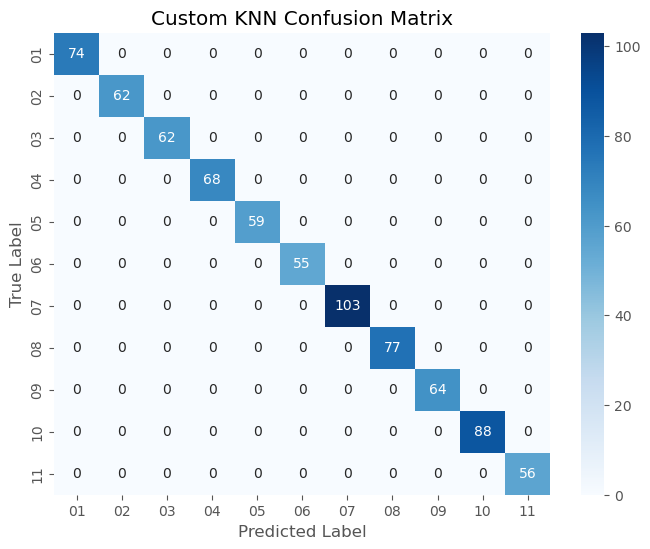


--- Evaluating scikit-learn Decision Tree Classifier ---
Decision Tree Accuracy: 0.9987

Decision Tree Confusion Matrix:
 [[ 74   0   0   0   0   0   0   0   0   0   0]
 [  0  62   0   0   0   0   0   0   0   0   0]
 [  0   0  62   0   0   0   0   0   0   0   0]
 [  0   1   0  67   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0]
 [  0   0   0   0   0  55   0   0   0   0   0]
 [  0   0   0   0   0   0 103   0   0   0   0]
 [  0   0   0   0   0   0   0  77   0   0   0]
 [  0   0   0   0   0   0   0   0  64   0   0]
 [  0   0   0   0   0   0   0   0   0  88   0]
 [  0   0   0   0   0   0   0   0   0   0  56]]

Decision Tree Classification Report:
               precision    recall  f1-score   support

          01       1.00      1.00      1.00        74
          02       0.98      1.00      0.99        62
          03       1.00      1.00      1.00        62
          04       1.00      0.99      0.99        68
          05       1.00      1.00      1.00      

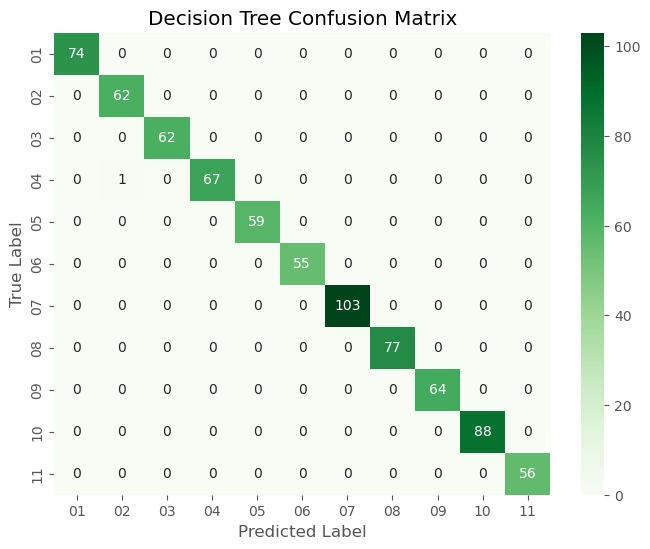

In [82]:
# Cell 9: Model Evaluation

if 'custom_knn' in locals() and 'tree' in locals() and 'X_test_scaled' in locals():
    # Evaluate Custom KNN
    print("\n--- Evaluating Custom KNN Classifier ---")
    y_pred_custom_knn = custom_knn.predict(X_test_scaled)
    accuracy_custom_knn = accuracy_score(y_test, y_pred_custom_knn)
    conf_matrix_custom_knn = confusion_matrix(y_test, y_pred_custom_knn)
    class_report_custom_knn = classification_report(y_test, y_pred_custom_knn, target_names=class_names)

    print(f"Custom KNN Accuracy: {accuracy_custom_knn:.4f}")
    print("\nCustom KNN Confusion Matrix:\n", conf_matrix_custom_knn)
    print("\nCustom KNN Classification Report:\n", class_report_custom_knn)

    # Visualize Custom KNN Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_custom_knn, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Custom KNN Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


    # Evaluate scikit-learn Decision Tree
    print("\n--- Evaluating scikit-learn Decision Tree Classifier ---")
    y_pred_tree = tree.predict(X_test_scaled)
    accuracy_tree = accuracy_score(y_test, y_pred_tree)
    conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
    class_report_tree = classification_report(y_test, y_pred_tree, target_names=class_names)

    print(f"Decision Tree Accuracy: {accuracy_tree:.4f}")
    print("\nDecision Tree Confusion Matrix:\n", conf_matrix_tree)
    print("\nDecision Tree Classification Report:\n", class_report_tree)

    # Visualize scikit-learn Decision Tree Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_tree, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Decision Tree Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

else:
    print("Skipping model evaluation: Models or test data not available.")

In [83]:
# Cell 10: GUI Class Definition 

import tkinter as tk
from tkinter import filedialog, ttk
from PIL import Image, ImageTk
import os
import numpy as np
import cv2
from skimage.feature import hog

# Ensure extract_features function is available (from Cell 4)

class PersonIdentificationGUI:
    # Corrected __init__ method name with double underscores
    def __init__(self, master, knn_model, tree_model, class_names, X_train_raw, y_train_raw, scaler):
        self.master = master
        master.title("Interpretable Person Identification")

        self.knn_model = knn_model # Custom_knn
        self.tree_model = tree_model
        self.class_names = class_names
        self.X_train_raw = X_train_raw # Unscaled training features
        self.y_train_raw = y_train_raw # Training labels
        self.scaler = scaler

        self.target_size = (128, 128) # Target size for face images

        self.cap = None # Webcam capture object
        self.webcam_active = False
        # Load Haar Cascade for face detection
        # IMPORTANT: This path assumes 'haarcascade_frontalface_default.xml' is in the
        # same directory as your notebook (your PYTHONFACIALRECOGNITION folder).
        self.face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        if self.face_cascade.empty():
            print("WARNING: haarcascade_frontalface_default.xml not found or failed to load.")
            print("Face detection in webcam will not work. Ensure the file is in the project folder.")
            print("Download from: https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml")


        # UI Elements
        self.create_widgets()
        print("DEBUG: PersonIdentificationGUI initialized successfully.") 

    def create_widgets(self):
        # Frame for image loading and prediction
        image_frame_section = tk.LabelFrame(self.master, text="Image File Prediction", padx=10, pady=10)
        image_frame_section.pack(padx=10, pady=10, fill="x")

        tk.Label(image_frame_section, text="Select an image for prediction:").pack(pady=5)
        tk.Button(image_frame_section, text="Load Image", command=self.load_image).pack(pady=5)

        self.image_display_frame = tk.Frame(image_frame_section, width=150, height=150, bd=2, relief="groove")
        self.image_display_frame.pack(pady=10)
        self.image_display_frame.pack_propagate(False) # Prevents frame from resizing to image

        self.canvas_label = tk.Label(self.image_display_frame)
        self.canvas_label.pack()

        tk.Button(image_frame_section, text="Predict (Custom KNN)", command=self.predict_knn).pack(pady=5)
        tk.Button(image_frame_section, text="Predict (Decision Tree)", command=self.predict_tree).pack(pady=5)
        self.result_label = tk.Label(image_frame_section, text="Prediction: N/A")
        self.result_label.pack(pady=10)
        tk.Button(image_frame_section, text="Show Interpretation (Decision Tree)", command=self.show_interpretation).pack(pady=5)

        # For Webcam Live Demo
        webcam_frame_section = tk.LabelFrame(self.master, text="Webcam Live Demonstration", padx=10, pady=10)
        webcam_frame_section.pack(padx=10, pady=10, fill="x")

        tk.Button(webcam_frame_section, text="Start Webcam Live Demo", command=self.start_webcam_demo).pack(pady=5)
        tk.Button(webcam_frame_section, text="Stop Webcam Demo", command=self.stop_webcam_demo).pack(pady=5)

        self.webcam_label = tk.Label(webcam_frame_section)
        self.webcam_label.pack(pady=10)
        self.webcam_status_label = tk.Label(webcam_frame_section, text="Webcam Status: Inactive")
        self.webcam_status_label.pack(pady=5)


        # Placeholder for image data
        self.current_image_path = None
        self.current_processed_image = None
        self.current_features = None # Unscaled features
        self.current_features_scaled = None # Scaled features

    def load_image(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("Image files", "*.png;*.jpg;*.jpeg;*.gif;*.bmp")]
        )
        if file_path:
            try:
                print(f"DEBUG: Attempting to load image from: {file_path}")
                img = cv2.imread(file_path)

                if img is None:
                    print(f"ERROR: cv2.imread failed for {file_path}. Image might be corrupt or unsupported.")
                    self.result_label.config(text=f"Error: Could not read image file.", fg="red")
                    self.current_image_path = None
                    self.current_processed_image = None
                    self.current_features = None
                    self.current_features_scaled = None
                    return # Exit function if image read fails

                print(f"DEBUG: Image loaded successfully. Shape: {img.shape}")
                img_resized = cv2.resize(img, self.target_size)
                self.current_processed_image = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB) # Store for feature extraction
                self.current_image_path = file_path

                # Display image
                img_display = Image.fromarray(self.current_processed_image)
                img_display.thumbnail((140, 140)) # Fit within frame
                # FIX: Store photo as an instance variable to prevent garbage collection
                self.photo = ImageTk.PhotoImage(img_display)

                self.canvas_label.config(image=self.photo) # Use self.photo
                # self.canvas_label.image = photo # This line is now redundant if you use self.photo directly in config

                # Extract features immediately upon loading
                print(f"DEBUG: Starting feature extraction for image: {os.path.basename(file_path)}")
                self.current_features = extract_features(np.array([self.current_processed_image]))[0]
                print(f"DEBUG: Features extracted. Shape: {self.current_features.shape}")

                # Scale the extracted features using the pre-fitted scaler
                print("DEBUG: Scaling features...")
                self.current_features_scaled = self.scaler.transform(self.current_features.reshape(1, -1))
                print("DEBUG: Features scaled successfully.")

                self.result_label.config(text=f"Image loaded: {os.path.basename(file_path)}", fg="black")
            except Exception as e:
                # This will catch any error during processing after cv2.imread
                print(f"CRITICAL ERROR in load_image processing: {e}")
                import traceback
                traceback.print_exc() # Print full traceback to console for detailed error
                self.result_label.config(text=f"Error processing image: {e}", fg="red")
                self.current_image_path = None
                self.current_processed_image = None
                self.current_features = None
                self.current_features_scaled = None

    def predict_knn(self):
        if self.current_features_scaled is not None:
            try:
                prediction_idx = self.knn_model.predict(self.current_features_scaled)[0]
                predicted_class_name = self.class_names[prediction_idx]
                self.result_label.config(text=f"Custom KNN Prediction: {predicted_class_name}", fg="blue")
            except Exception as e:
                self.result_label.config(text=f"Error during Custom KNN prediction: {e}", fg="red")
        else:
            self.result_label.config(text="Please load an image first.", fg="red")

    def predict_tree(self):
        if self.current_features_scaled is not None:
            try:
                prediction_idx = self.tree_model.predict(self.current_features_scaled)[0]
                predicted_class_name = self.class_names[prediction_idx]
                self.result_label.config(text=f"Decision Tree Prediction: {predicted_class_name}", fg="green")
            except Exception as e:
                self.result_label.config(text=f"Decision Tree Prediction: {e}", fg="red")
        else:
            self.result_label.config(text="Please load an image first.", fg="red")

    def show_interpretation(self):
        if self.current_features_scaled is not None and self.tree_model is not None:
            # Decision path for the current prediction
            node_indicator = self.tree_model.decision_path(self.current_features_scaled)
            leaf_id = self.tree_model.apply(self.current_features_scaled)

            feature_names = [f'feature_{i}' for i in range(self.X_train_raw.shape[1])]

            interpretation_text = "Decision Path (Decision Tree Interpretation):\\n"
            interpretation_text += "This path shows the sequence of decisions the tree made to classify the image.\\n"
            interpretation_text += "Each line represents a node where a feature's value was compared to a threshold.\\n\\n"

            for node_id in node_indicator.indices:
                if leaf_id[0] == node_id: # Reached leaf node
                    predicted_class_idx = self.tree_model.tree_.value[node_id].argmax()
                    interpretation_text += f"  -> Reached final decision node (Predicted Class: {self.class_names[predicted_class_idx]})\\n"
                    break # Exit loop once leaf is reached

                # Retrieve the feature index and threshold at this node
                feature_index = self.tree_model.tree_.feature[node_id]
                threshold = self.tree_model.tree_.threshold[node_id]

                if feature_index != -2: # -2 indicates a leaf node or a node without a split
                    # Get the actual value of the feature for the current image
                    current_feature_value = self.current_features_scaled[0, feature_index]

                    # Determine which branch was taken (left or right)
                    if current_feature_value <= threshold:
                        direction = "LEFT (<= threshold)"
                    else:
                        direction = "RIGHT (> threshold)"
                    interpretation_text += (
                        f"  - Node {node_id}: Is {feature_names[feature_index]} (value={current_feature_value:.4f}) "
                        f"<= {threshold:.4f}? -> {direction}\\n"
                    )

            # Display interpretation in a new pop-up window 
            interpretation_window = tk.Toplevel(self.master)
            interpretation_window.title("Decision Tree Interpretation")

            # Use a Text widget for scrollable, multi-line text
            text_area = tk.Text(interpretation_window, wrap="word", width=80, height=20, font=("TkDefaultFont", 10))
            text_area.pack(padx=10, pady=10, fill="both", expand=True)

            text_area.insert(tk.END, interpretation_text)
            text_area.config(state="disabled") # Make text read-only

            # Add a scrollbar to the text area
            scrollbar = ttk.Scrollbar(interpretation_window, command=text_area.yview)
            scrollbar.pack(side="right", fill="y")
            text_area.config(yscrollcommand=scrollbar.set)

            self.result_label.config(text="Interpretation displayed in a new window.", fg="purple")


        else:
            self.result_label.config(text="Load an image and ensure Decision Tree model is trained first.", fg="red")

    def start_webcam_demo(self):
        if self.face_cascade.empty():
            self.webcam_status_label.config(text="Error: Haar Cascade not loaded. Cannot start webcam.", fg="red")
            return

        if self.cap is None or not self.cap.isOpened():
            self.cap = cv2.VideoCapture(0) # 0 for default webcam
            if not self.cap.isOpened():
                self.webcam_status_label.config(text="Error: Could not open webcam.", fg="red")
                self.webcam_active = False
                return
            else:
                self.webcam_status_label.config(text="Webcam Status: Active", fg="green")
                self.webcam_active = True
                self.update_frame()
        else:
            self.webcam_status_label.config(text="Webcam Status: Already active.", fg="orange")

    def stop_webcam_demo(self):
        if self.cap is not None and self.cap.isOpened():
            self.cap.release()
            self.webcam_active = False
            self.webcam_label.config(image='') # Clear the display
            self.webcam_status_label.config(text="Webcam Status: Inactive", fg="black")
            print("Webcam stopped.")
        else:
            self.webcam_status_label.config(text="Webcam Status: Not active.", fg="orange")

    def update_frame(self):
        if self.webcam_active and self.cap.isOpened():
            ret, frame = self.cap.read()
            if ret:
                # Convert frame to RGB for display and processing
                cv_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                display_image = cv_image.copy() # Make a copy for drawing on

                # Perform face detection
                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces = self.face_cascade.detectMultiScale(gray_frame, 1.1, 4)

                for (x, y, w, h) in faces:
                    # Extract face region
                    face_roi = cv_image[y:y+h, x:x+w]

                    if face_roi.size == 0: # Check if face_roi is empty
                        continue

                    # Resize face for feature extraction
                    face_resized = cv2.resize(face_roi, self.target_size)

                    # Extract features
                    try:
                        features = extract_features(np.array([face_resized]))[0]
                        features_scaled = self.scaler.transform(features.reshape(1, -1))

                        # Predict using Decision Tree (can switch to KNN if desired)
                        prediction_idx = self.tree_model.predict(features_scaled)[0]
                        predicted_class_name = self.class_names[prediction_idx]

                        # Draw bounding box and label
                        cv2.rectangle(display_image, (x, y), (x+w, y+h), (255, 0, 0), 2) # Blue rectangle
                        cv2.putText(display_image, predicted_class_name, (x, y-10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2, cv2.LINE_AA)
                    except Exception as e:
                        # Handle cases where feature extraction or prediction fails for a frame
                        cv2.rectangle(display_image, (x, y), (x+w, y+h), (0, 0, 255), 2) # Red for error
                        cv2.putText(display_image, "Error", (x, y-10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2, cv2.LINE_AA)
                        print(f"Error processing face in webcam frame: {e}")


                # Convert image for Tkinter display
                img_display = Image.fromarray(display_image)
                img_display.thumbnail((640, 480)) # Limit display size
                photo = ImageTk.PhotoImage(img_display)

                self.webcam_label.config(image=photo)
                self.webcam_label.image = photo # Keep reference

                # Schedule the next frame update
                self.master.after(20, self.update_frame) # Update every 20ms (approx 50 fps)
            else:
                self.webcam_status_label.config(text="Error: Failed to read frame from webcam.", fg="red")
                self.stop_webcam_demo()
        elif self.webcam_active: # If webcam_active is true but cap is not open, something went wrong
            self.webcam_status_label.config(text="Webcam Status: Inactive (Error)", fg="red")
            self.stop_webcam_demo()

In [84]:
# Cell 11: Launch GUI
import tkinter as tk 
from PIL import ImageTk # Import ImageTk for the GUI

def launch_gui(knn_model, tree_model, class_names, X_train_features_unscaled, y_train_labels, scaler):
    """
    Launches the Person Identification GUI.

    Args:
        knn_model: The trained Custom KNN model.
        tree_model: The trained Decision Tree model.
        class_names: List of class names (person identities).
        X_train_features_unscaled: The unscaled training features (from train_test_split).
        y_train_labels: The training labels.
        scaler: The fitted StandardScaler object.
    """
    root = tk.Tk()
    # Pass the unscaled X_train and y_train to the GUI, as it expects raw features
    # for potential future interpretation methods that might need them.
    app = PersonIdentificationGUI(root, knn_model, tree_model, class_names, X_train_features_unscaled, y_train_labels, scaler)
    # Ensure webcam is released when the window is closed
    root.protocol("WM_DELETE_WINDOW", lambda: on_closing(root, app))
    root.mainloop()

def on_closing(root, app):
    """Handles window closing event to release webcam."""
    app.stop_webcam_demo()
    root.destroy()

print("\n--- Checking variables before GUI launch ---")
print(f"custom_knn in globals(): {'custom_knn' in globals()}")
print(f"tree in globals(): {'tree' in globals()}")
print(f"scaler in globals(): {'scaler' in globals()}")
print(f"X_train in globals(): {'X_train' in globals()}")
print(f"y_train in globals(): {'y_train' in globals()}")
print(f"class_names in globals(): {'class_names' in globals()}")
print("------------------------------------------")


# Launch if we have trained models and scaler is available
if 'custom_knn' in globals() and 'tree' in globals() and 'scaler' in globals() and \
   'X_train' in globals() and 'y_train' in globals() and 'class_names' in globals():
    print("\nLaunching GUI...")
    # These are the variables holding the unscaled training features and labels
    # after the train_test_split in your notebook (e.g., from Cell 5).
    launch_gui(custom_knn, tree, class_names, X_train, y_train, scaler)
else:
    print("GUI not launched - models, scaler, or data not available. Ensure all previous cells ran successfully.")

print("End of notebook.")


--- Checking variables before GUI launch ---
custom_knn in globals(): True
tree in globals(): True
scaler in globals(): True
X_train in globals(): True
y_train in globals(): True
class_names in globals(): True
------------------------------------------

Launching GUI...
DEBUG: PersonIdentificationGUI initialized successfully.
DEBUG: Attempting to load image from: C:/Users/Admin/Downloads/data/person2/frame_00097.jpg
DEBUG: Image loaded successfully. Shape: (1280, 720, 3)
DEBUG: Starting feature extraction for image: frame_00097.jpg
Extracting features (HOG + HSV)...
  Processing image 0/1
Feature extraction complete. Total features extracted: 1
DEBUG: Features extracted. Shape: (8164,)
DEBUG: Scaling features...
DEBUG: Features scaled successfully.
End of notebook.
